In [1]:
# STEP 1: Install kaggle
!pip install kaggle

# STEP 2: Upload kaggle.json
from google.colab import files
files.upload()  # ⬅️ Upload your kaggle.json when prompted

# STEP 3: Set Kaggle credentials
import os
import json

with open("kaggle.json", "r") as f:
    kaggle_creds = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

# STEP 4: Download the CREMA-D dataset
!kaggle datasets download -d ejlok1/cremad -p crema --unzip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)


In [2]:
import os
import pandas as pd

# Path to dataset folder
crema_path = "/content/crema/AudioWAV"
file_emotion = []
file_path = []

# List all files in folder
crema_directory_list = os.listdir(crema_path)

for file in crema_directory_list:
    if file.endswith(".wav"):
        path = os.path.join(crema_path, file)

        # Extract emotion from filename
        parts = file.split('_')
        if len(parts) >= 4:
            emotion_code = parts[2]
            file_path.append(path)
            if emotion_code == 'SAD':
                file_emotion.append('sad')
            elif emotion_code == 'ANG':
                file_emotion.append('angry')
            elif emotion_code == 'DIS':
                file_emotion.append('disgust')
            elif emotion_code == 'FEA':
                file_emotion.append('fear')
            elif emotion_code == 'HAP':
                file_emotion.append('happy')
            elif emotion_code == 'NEU':
                file_emotion.append('neutral')
            else:
                file_emotion.append('unknown')
        else:
            # Skip invalid files
            continue

# Create dataframe
Crema_df = pd.DataFrame({
    'Emotions': file_emotion,
    'Path': file_path
})

# Show sample
Crema_df.head()


,Emotions,Path
0,neutral,/content/crema/AudioWAV/1012_ITH_NEU_XX.wav
1,disgust,/content/crema/AudioWAV/1003_IOM_DIS_XX.wav
2,neutral,/content/crema/AudioWAV/1052_TIE_NEU_XX.wav
3,sad,/content/crema/AudioWAV/1064_TSI_SAD_XX.wav
4,angry,/content/crema/AudioWAV/1004_IWW_ANG_XX.wav


In [3]:
# Install missing packages (if needed)
!pip install librosa --quiet
!pip install scikit-learn --quiet

# Imports
import os
import sys
import warnings

import pandas as pd
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

# Use tensorflow.keras instead of standalone keras (recommended in Colab)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Suppress warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)



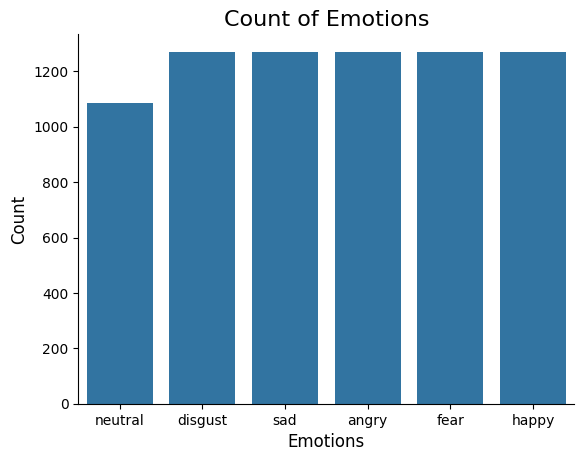

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=Crema_df.Emotions)  # or sns.countplot(data=Crema_df, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(data, sr=sr)
    plt.title(f"Waveplot for audio with {e} emotion", size=15)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()







In [6]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

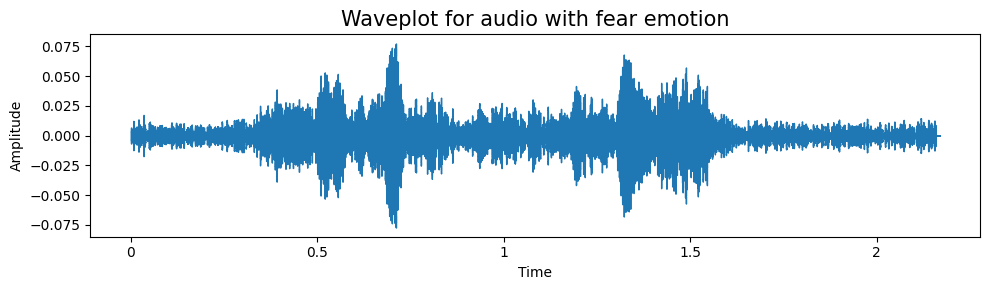

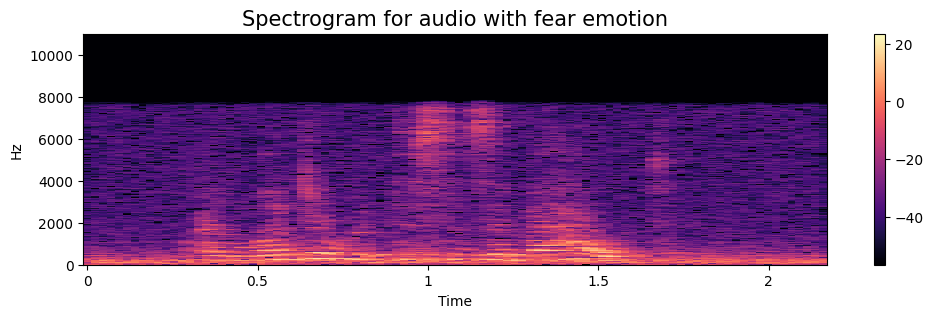

In [8]:
emotion='fear'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

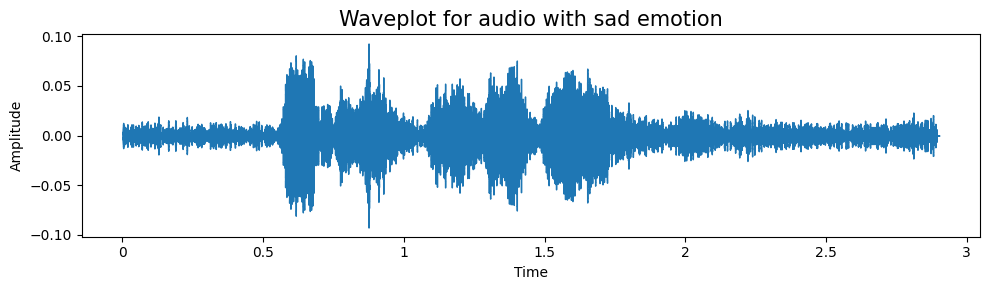

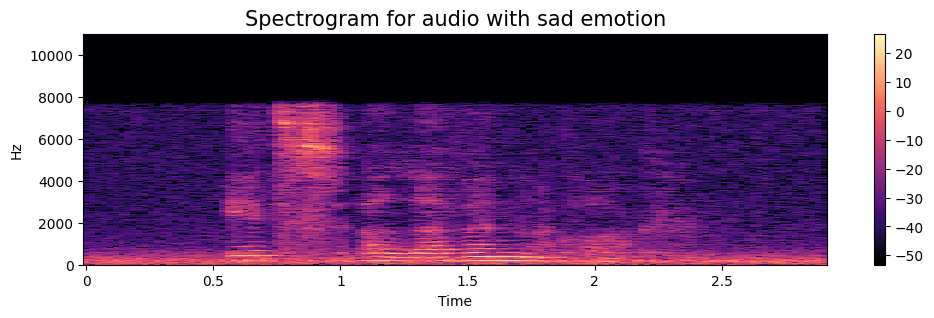

In [9]:
emotion='sad'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

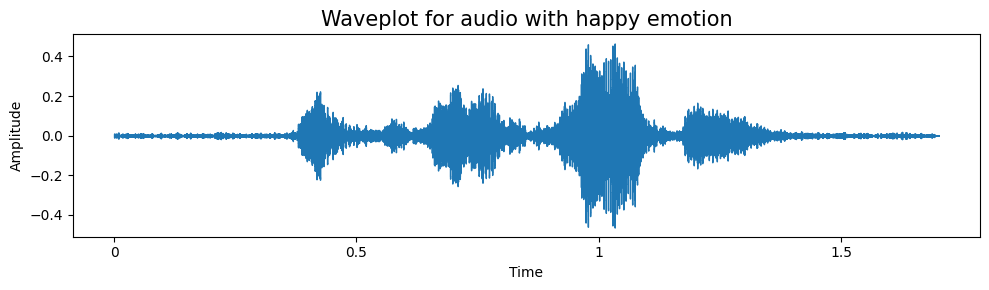

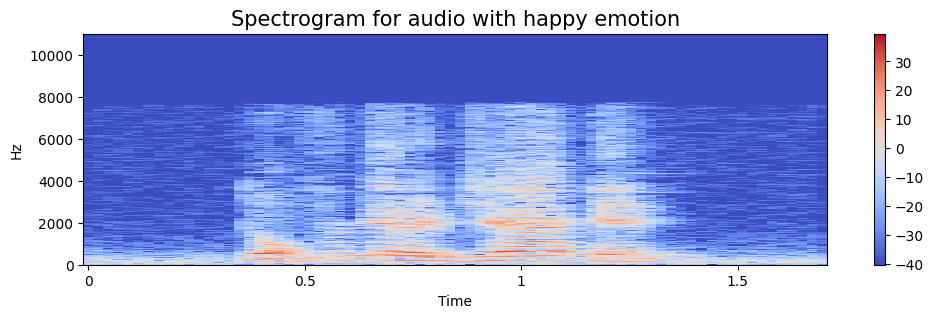

In [10]:
emotion='happy'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, sr, rate=0.8):
    return librosa.resample(data, orig_sr=sr, target_sr=int(sr * rate))

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)



# taking any example and checking for techniques.
path = np.array(Crema_df.Path)[1]
data, sample_rate = librosa.load(path)

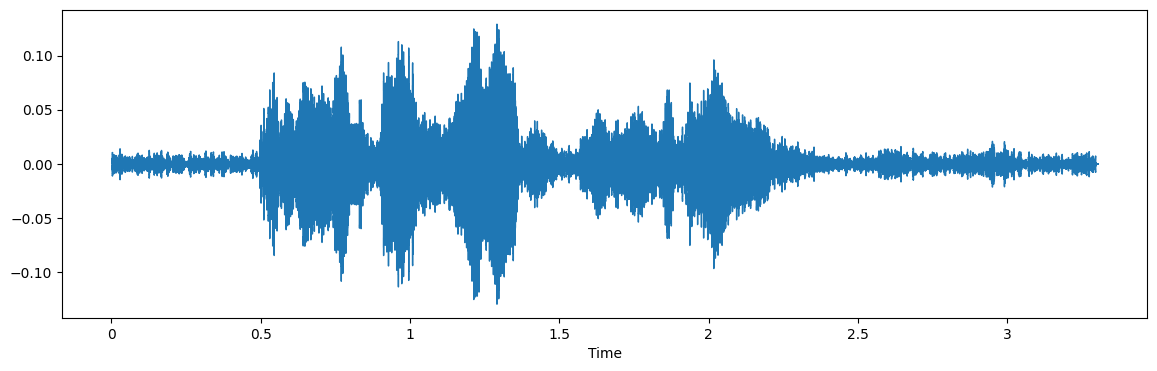

In [12]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

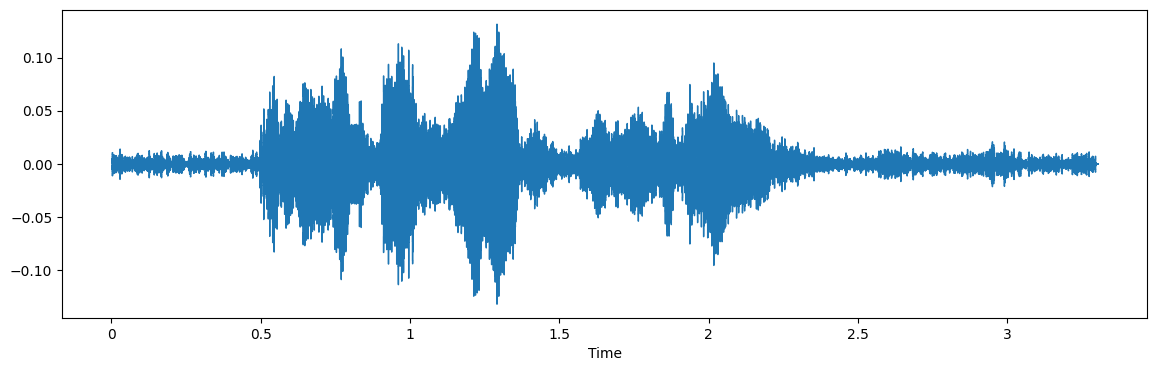

In [13]:
x = stretch(data, sr=sample_rate)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=int(sample_rate * 0.8))
Audio(x, rate=int(sample_rate * 0.8))


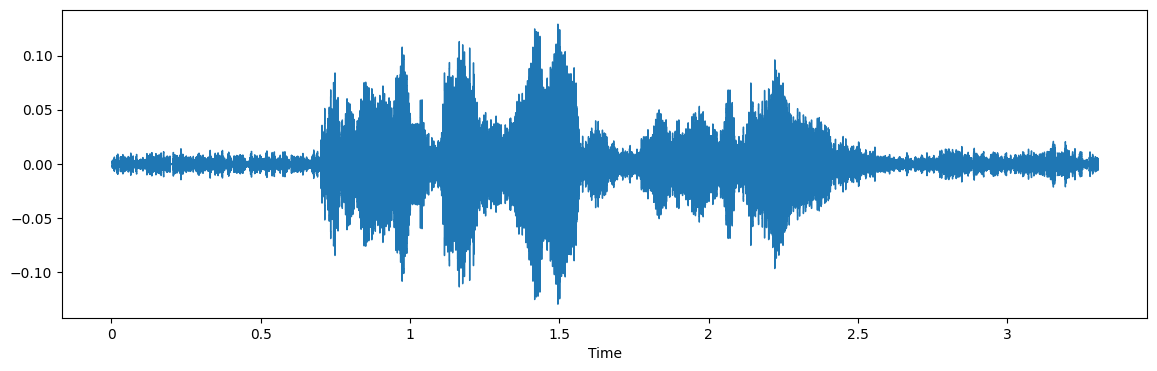

In [14]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

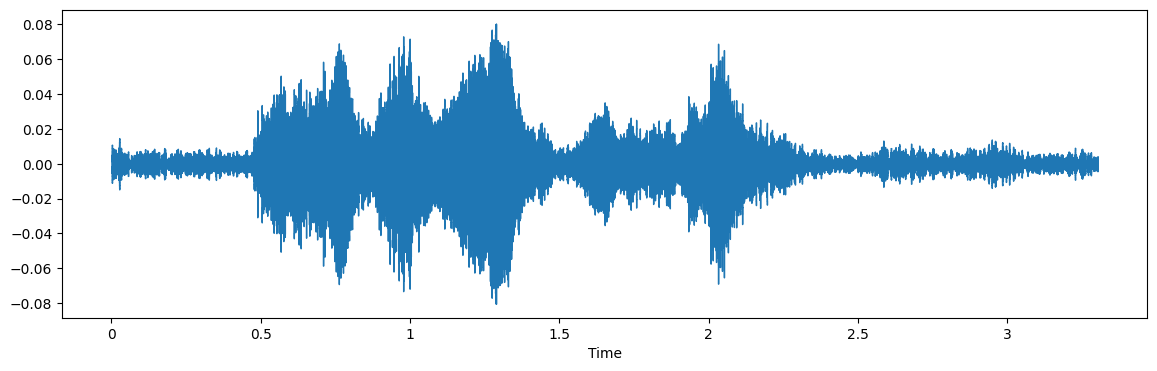

In [15]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)



In [16]:
import librosa
print(librosa.__version__)
print(librosa.effects.pitch_shift)



0.11.0
<function pitch_shift at 0x7b5992f44040>


In [17]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # 1st feature set - original data
    result = extract_features(data)

    # 2nd - noise added
    noise_data = noise(data)
    res1 = extract_features(noise_data)
    result = np.vstack((result, res1))

    # 3rd - stretched + pitch shifted
    new_data = stretch(data, sr=sample_rate)
    data_stretch_pitch = pitch(new_data, sample_rate)  # <-- UNCOMMENT this line
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))

    return result


In [18]:
X, Y = [], []
for path, emotion in zip(Crema_df.Path, Crema_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [19]:
len(X), len(Y), Crema_df.Path.shape

(22326, 22326, (7442,))

In [20]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.051324,0.624563,0.649637,0.477393,0.418248,0.521760,0.445117,0.399002,0.425673,0.579655,...,6.014593e-07,5.585290e-07,5.281400e-07,5.055471e-07,4.887467e-07,4.767180e-07,4.679931e-07,4.623854e-07,4.588964e-07,neutral
1,0.091589,0.589028,0.746758,0.625913,0.496785,0.596190,0.561763,0.448465,0.453595,0.550169,...,3.070499e-04,3.299819e-04,2.964009e-04,3.125690e-04,3.192824e-04,3.092448e-04,3.242160e-04,3.165056e-04,3.134498e-04,neutral
2,0.066475,0.464621,0.654639,0.682318,0.399735,0.484551,0.664163,0.504565,0.341885,0.444025,...,9.164866e-05,1.280135e-04,9.708552e-05,9.502254e-05,4.265830e-05,2.740650e-05,1.598438e-06,2.304937e-07,4.176845e-08,neutral
3,0.074490,0.642650,0.597429,0.641529,0.634411,0.597689,0.649356,0.557372,0.500379,0.486527,...,1.166244e-08,1.099069e-08,1.051207e-08,1.015330e-08,9.886048e-09,9.696556e-09,9.559314e-09,9.473091e-09,9.418577e-09,disgust
4,0.104167,0.669487,0.623692,0.672717,0.672891,0.638399,0.673760,0.570102,0.518293,0.500304,...,1.026903e-04,9.936684e-05,9.926932e-05,1.024103e-04,1.019130e-04,1.040784e-04,9.441787e-05,9.292916e-05,9.660011e-05,disgust


In [27]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an example audio file
file_path = Crema_df.Path[0]  # you can choose any file
y, sr = librosa.load(file_path)

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
print("MFCC shape:", mfccs.shape)  # (40, time_frames)


MFCC shape: (40, 105)


In [29]:
# Step 1: Prepare X and Y
X = Features.iloc[:, :-1].values
Y = Features['labels'].values

# Step 2: One-hot encode Y (for multiclass classification)
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# Step 3: Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

# Step 4: Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Step 5: Reshape for Conv1D
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(162, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 160, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 78, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 39, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 39, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4992)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       319,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,902 (1.32 MB)

 Trainable params: 344,902 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(x_test, y_test)
)


Epoch 1/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.3231 - loss: 1.6107 - val_accuracy: 0.4120 - val_loss: 1.4367
Epoch 2/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.3973 - loss: 1.4656 - val_accuracy: 0.4235 - val_loss: 1.3814
Epoch 3/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.4267 - loss: 1.4108 - val_accuracy: 0.4472 - val_loss: 1.3520
Epoch 4/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.4281 - loss: 1.4006 - val_accuracy: 0.4604 - val_loss: 1.3432
Epoch 5/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.4437 - loss: 1.3706 - val_accuracy: 0.4631 - val_loss: 1.3231
Epoch 6/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.4541 - loss: 1.3495 - val_accuracy: 0.4667 - val_loss: 1.3294
Epoch 7/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.4634 - loss: 1.3445 - val_accuracy: 0.4712 - val_loss: 1.3067
Epoch 8/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.4599 - loss: 1.3323 - 

In [32]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_acc)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5061 - loss: 1.2376
Test Accuracy: 0.5060909986495972


In [25]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162, 1), (16744, 6), (5582, 162, 1), (5582, 6))

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# Reshape x_train and x_test to 2D for DecisionTreeClassifier
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Now you can fit the DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
clf.fit(x_train, y_train)
# Initialize and train
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
clf.fit(x_train, y_train)

# Predictions
y_pred = clf.predict(x_test)

# Accuracy & metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(10, 6))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Accuracy: 0.25743461125044786
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       966
           1       0.38      0.15      0.21       903
           2       0.45      0.19      0.27       977
           3       0.41      0.21      0.28       937
           4       0.37      0.09      0.15       819
           5       0.52      0.34      0.41       980

   micro avg       0.51      0.26      0.34      5582
   macro avg       0.47      0.25      0.32      5582
weighted avg       0.47      0.26      0.32      5582
 samples avg       0.26      0.26      0.26      5582



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: multilabel-indicator is not supported

<Figure size 1000x600 with 0 Axes>

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
num_emotions = 6
X = X.reshape(X.shape[0], X.shape[1], 1)  # Add an extra dimension for channels

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# No need to expand dimensions again as it's already done
#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
model = Sequential()

# Convolutional Layers
model.add(Conv1D(128, kernel_size=5, strides=1, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Recurrent Layers (LSTM)
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))

# Fully Connected Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_emotions, activation='softmax'))  # num_emotions should be 6 for CREMA-D

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 158, 128)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 158, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 79, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 79, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 77, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 77, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 38, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,118 (289.52 KB)

 Trainable params: 73,734 (288.02 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from keras.callbacks import ReduceLROnPlateau

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=3, verbose=1, min_lr=1e-7)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 66s 199ms/step - accuracy: 0.2736 - loss: 1.6545 - val_accuracy: 0.1731 - val_loss: 3.2655 - learning_rate: 0.0010
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 69s 152ms/step - accuracy: 0.3536 - loss: 1.5285 - val_accuracy: 0.1731 - val_loss: 3.4616 - learning_rate: 0.0010
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 38s 146ms/step - accuracy: 0.3796 - loss: 1.5090 - val_accuracy: 0.2146 - val_loss: 1.7897 - learning_rate: 0.0010
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - accuracy: 0.3806 - loss: 1.4993 - val_accuracy: 0.3551 - val_loss: 1.5716 - learning_rate: 0.0010
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 42s 153ms/step - accuracy: 0.3721 - loss: 1.5136 - val_accuracy: 0.2175 - val_loss: 1.8053 - learning_rate: 0.0010
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.3794 - loss: 1.4940 - val_accuracy: 0.4056 - val_loss: 1.4465 - learning_rate: 0.0010
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.3

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization, Dropout,
                                     Reshape, LSTM, Dense, Flatten, TimeDistributed)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 👇 Replace these with your actual data
# x_train, x_test: shape -> (samples, time, freq)  e.g. (2000, 128, 128)
# y_train, y_test: one-hot encoded labels (e.g. (2000, 6))
x_train = np.load("x_train.npy")
x_test = np.load("x_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Reshape to include channel dimension
x_train = x_train[..., np.newaxis]  # shape: (samples, 128, 128, 1)
x_test = x_test[..., np.newaxis]

# 🔧 Model
model = Sequential()

# --- CNN Layers ---
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# --- Reshape for LSTM ---
model.add(Reshape((x_train.shape[1]//4, -1)))  # shape: (batch, time, features)

# --- RNN Layer ---
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))

# --- Dense Layer ---
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))  # 6 classes in CREMA-D

# --- Compile ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Callbacks ---
rlrp = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# --- Train ---
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[rlrp, early_stop]
)


175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step
Accuracy: 0.1797

Classification Report:
              precision    recall  f1-score   support

           0       0.17      1.00      0.30       966
           1       0.00      0.00      0.00       903
           2       0.73      0.04      0.07       977
           3       0.00      0.00      0.00       937
           4       0.00      0.00      0.00       819
           5       0.00      0.00      0.00       980

    accuracy                           0.18      5582
   macro avg       0.15      0.17      0.06      5582
weighted avg       0.16      0.18      0.06      5582



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


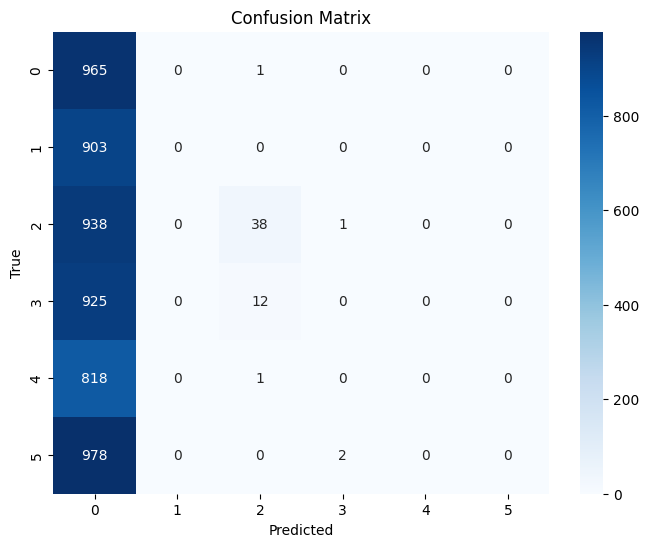

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,222 (2.13 MB)

 Trainable params: 557,222 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 123s 449ms/step - accuracy: 0.2884 - loss: 1.6672 - val_accuracy: 0.3853 - val_loss: 1.4859 - learning_rate: 0.0010
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 135s 423ms/step - accuracy: 0.3545 - loss: 1.5275 - val_accuracy: 0.3819 - val_loss: 1.4960 - learning_rate: 0.0010
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 139s 411ms/step - accuracy: 0.3761 - loss: 1.4928 - val_accuracy: 0.4020 - val_loss: 1.4236 - learning_rate: 0.0010
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 144s 420ms/step - accuracy: 0.3903 - loss: 1.4637 - val_accuracy: 0.4079 - val_loss: 1.4433 - learning_rate: 0.0010
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 142s 421ms/step - accuracy: 0.4042 - loss: 1.4467 - val_accuracy: 0.4196 - val_loss: 1.3964 - learning_rate: 0.0010
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 142s 420ms/step - accuracy: 0.4178 - loss: 1.4197 - val_accuracy: 0.4308 - val_loss: 1.3802 - learning_rate: 0.0010
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 142s 420ms/step - accura

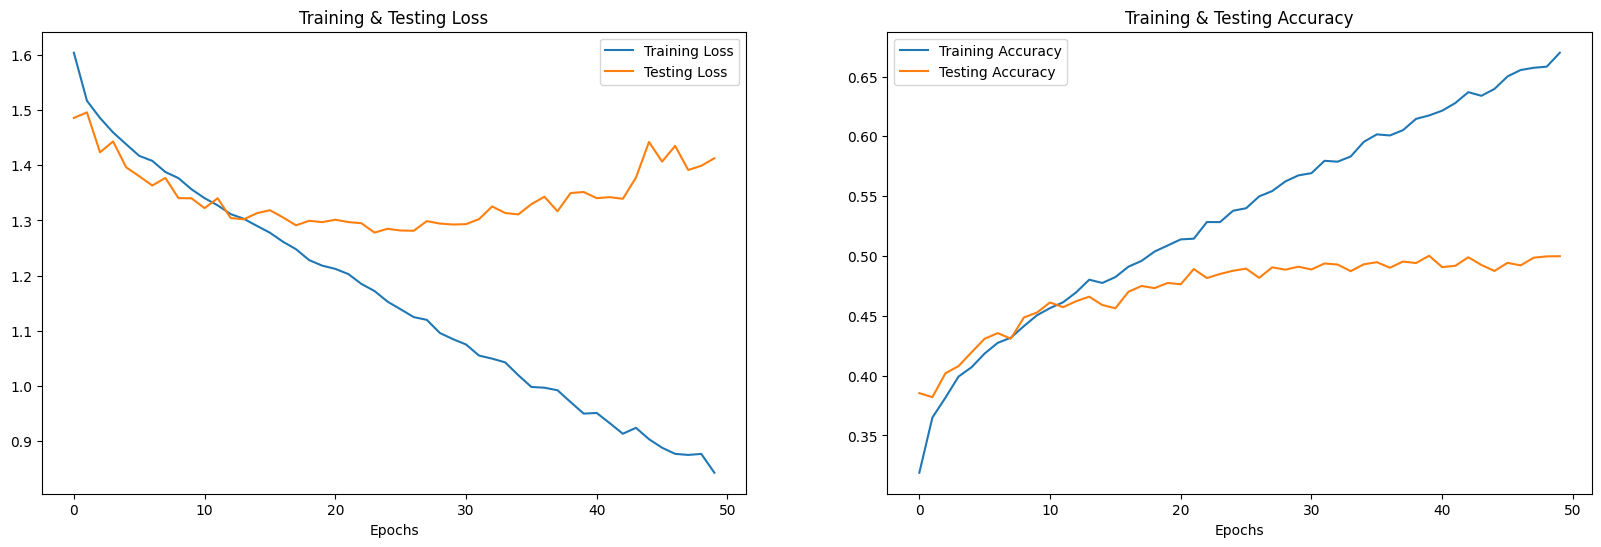

In [ ]:
# print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,happy,happy
1,angry,angry
2,fear,fear
3,neutral,neutral
4,neutral,disgust
5,happy,happy
6,happy,happy
7,angry,happy
8,sad,disgust
9,sad,sad


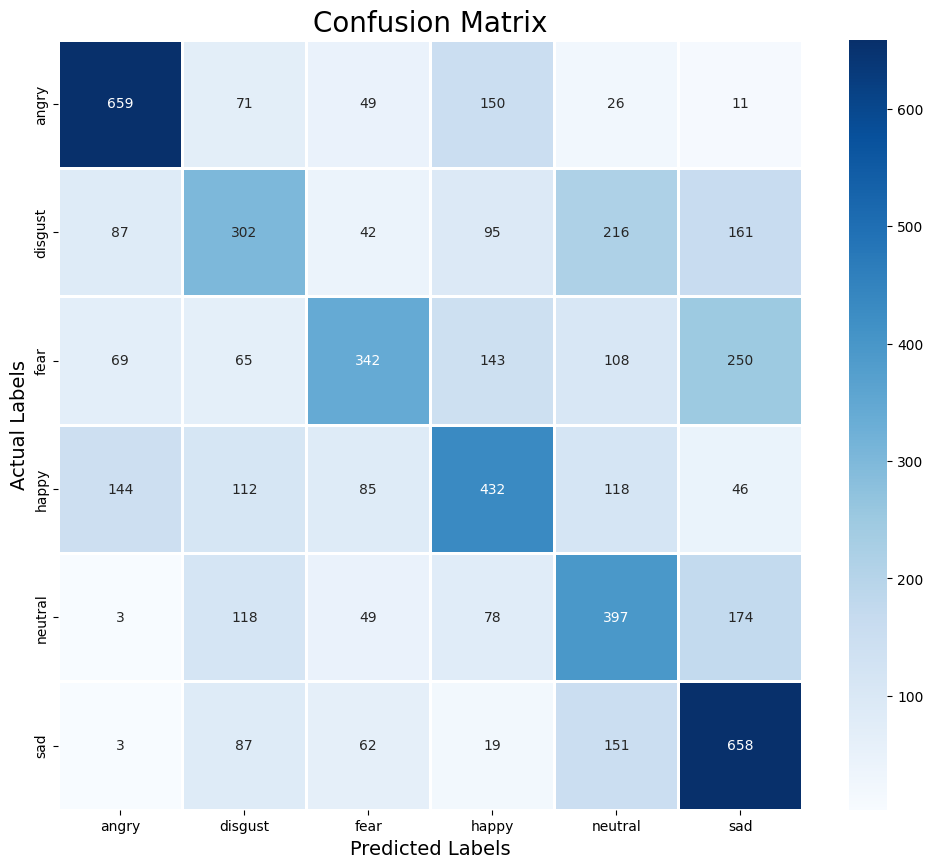

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.68      0.68      0.68       966
     disgust       0.40      0.33      0.36       903
        fear       0.54      0.35      0.43       977
       happy       0.47      0.46      0.47       937
     neutral       0.39      0.48      0.43       819
         sad       0.51      0.67      0.58       980

    accuracy                           0.50      5582
   macro avg       0.50      0.50      0.49      5582
weighted avg       0.50      0.50      0.49      5582

